In [47]:
# Import packages
import os
import re
import functools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from PIL import Image
from collections import Counter
from nltk.corpus import stopwords
import PIL

In [2]:
##example of an original xml file
import xml.etree.ElementTree as ET
tree = ET.parse('./ecgen-radiology/1.xml')
root = tree.getroot()

In [3]:
for child in root:
    print(child.tag, child.attrib)

meta {'type': 'rr'}
uId {'id': 'CXR1'}
pmcId {'id': '1'}
docSource {}
IUXRId {'id': '1'}
licenseType {}
licenseURL {}
ccLicense {}
articleURL {}
articleDate {}
articleType {}
publisher {}
title {}
note {}
specialty {}
subset {}
MedlineCitation {'Owner': 'Indiana University', 'Status': 'supplied by publisher'}
MeSH {}
parentImage {'id': 'CXR1_1_IM-0001-3001'}
parentImage {'id': 'CXR1_1_IM-0001-4001'}


In [4]:
## two impages sharing the same captions in 1.xml file
for child in root.findall('parentImage'):
    print(child.tag, child.attrib)

parentImage {'id': 'CXR1_1_IM-0001-3001'}
parentImage {'id': 'CXR1_1_IM-0001-4001'}


In [5]:
##caption for 'CXR1_1_IM-0001-3001' and 'CXR1_1_IM-0001-4001'
for child in root:
    if child.tag == 'MedlineCitation':
        for attr in child:
             if attr.tag == 'Article':
                for i in attr:
                    if i.tag == 'Abstract':
                        for name in i:
                            if name.get('Label') == 'IMPRESSION':
                                imp=name.text  

print(imp)


Normal chest x-XXXX.


In [44]:
# Load data :extract caption From the XML files
from tqdm import tqdm
import xml.etree.ElementTree as ET
img = []
img_impression = []
number = []
img_finding = []
directory = "./ecgen-radiology/"
num = 1
# directory--> directory containing report files
for filename in tqdm(os.listdir("./ecgen-radiology/")):
    if filename.endswith(".xml"):
        f = directory + '/' + filename
        tree = ET.parse(f)
        root = tree.getroot()
        for child in root:
            if child.tag == 'MedlineCitation':
                for attr in child:
                    if attr.tag == 'Article':
                        for i in attr:
                            if i.tag == 'Abstract':
                                for name in i:
                                    if name.get('Label') == 'IMPRESSION':
                                        imp=name.text
                                    if name.get('Label') == 'FINDINGS':
                                        finding=name.text
        for p_image in root.findall('parentImage'):
            img.append(p_image.get('id'))
            img_impression.append(imp)
            img_finding.append(finding)
            number.append(num)
        num = num+1
df = pd.DataFrame({"Image": img, "Caption": img_impression,"Number":number,"Findings":img_finding})
df.head()

100%|██████████| 3955/3955 [00:02<00:00, 1862.30it/s]


,Image,Caption,Number,Findings
0,CXR162_IM-0401-1001,Normal chest,1,Heart size normal. Lungs are clear. XXXX are n...
1,CXR162_IM-0401-2001,Normal chest,1,Heart size normal. Lungs are clear. XXXX are n...
2,CXR1390_IM-0249-1001,No evidence of active disease.,2,The heart size and pulmonary vascularity appea...
3,CXR1390_IM-0249-2001,No evidence of active disease.,2,The heart size and pulmonary vascularity appea...
4,CXR604_IM-2193-1001,1. No evidence of active disease.,3,The heart size and pulmonary vascularity appea...


In [45]:
df.to_csv("origin.csv",index=False)

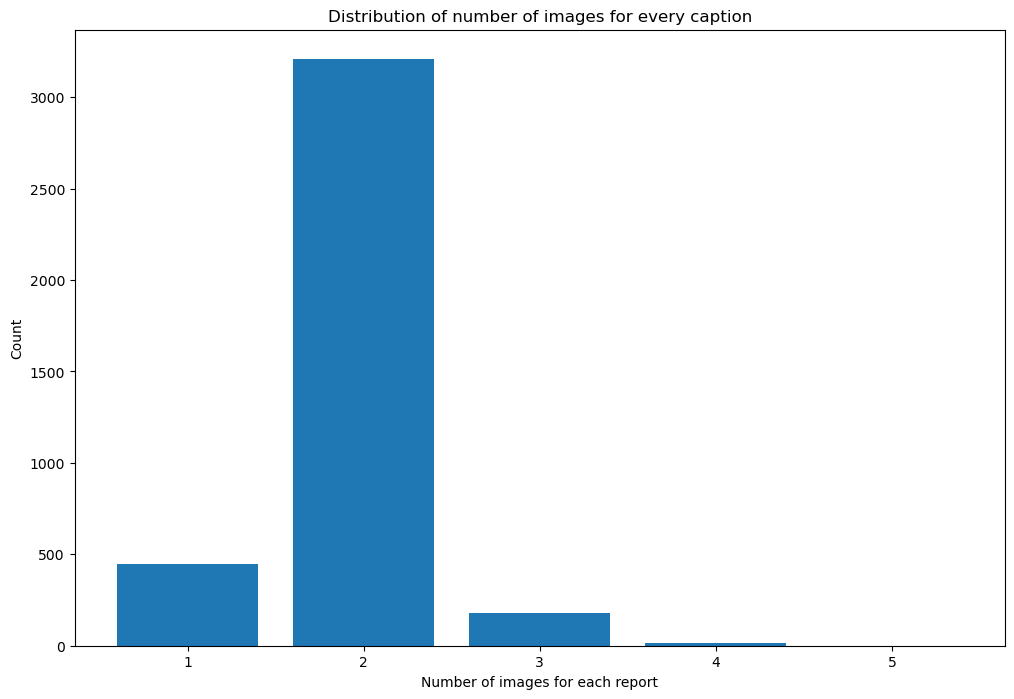

In [46]:
n_img = df.groupby(["Number"]).size().value_counts().reset_index()
n_img.columns = ["Number of Images", "Count"]

plt.figure(figsize=(12,8))
plt.bar(x=n_img["Number of Images"], height=n_img["Count"])
plt.xlabel("Number of images for each report")
plt.ylabel("Count")
plt.title("Distribution of number of images for every caption")
plt.show()

In [10]:
##check missing values
df.isnull().sum()

Image       0
Caption    52
Number      0
dtype: int64

In [53]:
import PIL
d = 'NLMCXR_png'
name = []
w = []
h = []

for filename in tqdm(os.listdir(d)):
    if filename.endswith(".png"):
        f = d + '/' + filename
        image = PIL.Image.open(f)
        width, height = image.size
        name.append(filename)
        w.append(width)
        h.append(height)

dfimage = pd.DataFrame({"Image": name,"width":w,"height":h})

100%|██████████| 7471/7471 [00:03<00:00, 2438.63it/s]


In [54]:
dfimage

,Image,width,height
0,CXR163_IM-0410-12012.png,512,624
1,CXR2595_IM-1086-2001.png,512,624
2,CXR1465_IM-0302-2001.png,512,624
3,CXR2835_IM-1251-1001.png,512,624
4,CXR855_IM-2376-1001.png,512,624
...,...,...,...
7465,CXR1863_IM-0558-3001.png,512,486
7466,CXR1207_IM-0140-0001-0001.png,512,618
7467,CXR2594_IM-1085-2001.png,512,624
7468,CXR1464_IM-0301-2001.png,512,512


In [59]:
print(pd.unique(dfimage["width"]))
## since only height is different, we only see the distribution of height

[512]


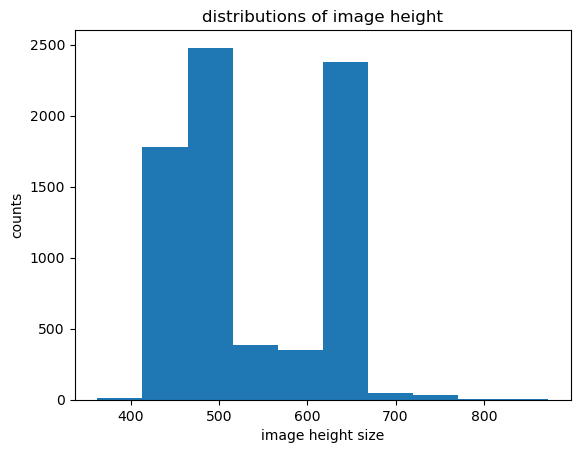

In [64]:
plt.hist(dfimage["height"])

plt.xlabel("image height size")
plt.ylabel("counts")
plt.title("distributions of image height")
plt.show()

In [29]:
# Load data :extract caption From the XML files
from tqdm import tqdm
import xml.etree.ElementTree as ET
img1 = []
img2 = []
img_finding = []
img_impression = []
number = []
directory = "./ecgen-radiology/"
num = 1
# directory--> directory containing report files
for filename in tqdm(os.listdir("./ecgen-radiology/")):
    if filename.endswith(".xml"):
        f = directory + '/' + filename
        tree = ET.parse(f)
        root = tree.getroot()
        for child in root:
            if child.tag == 'MedlineCitation':
                for attr in child:
                    if attr.tag == 'Article':
                        for i in attr:
                            if i.tag == 'Abstract':
                                for name in i:
                                    if name.get('Label') == 'IMPRESSION':
                                        imp=name.text
                                    if name.get('Label') == 'FINDINGS':
                                        finding=name.text
        
        id = root.findall('parentImage')
        
        if len(id)%2 == 0:
            p_image = 0
            while p_image < len(id):
                   
                img1.append(id[p_image].get('id'))
                p_image = p_image+1
                   
                img2.append(id[p_image].get('id'))
                p_image = p_image+1
                
                img_impression.append(imp)
                number.append(num)
                img_finding.append(finding)
                
        elif len(id)%2 == 1:
            p_image = 0
            while p_image < len(id)-1:
                img1.append(id[p_image].get('id'))
                p_image = p_image+1
                img2.append(id[p_image].get('id'))
                p_image = p_image+1
                
                img_impression.append(imp)
                number.append(num)
                img_finding.append(finding)
            
            img1.append(id[p_image].get('id'))
            img2.append(id[p_image].get('id'))
            img_impression.append(imp)
            img_finding.append(finding)
            number.append(num)
        
        num = num+1
df = pd.DataFrame({"Image1": img1,"Image2": img2, "Caption": img_impression,"Number":number,"Findings":img_finding}).sort_values(['Number'])


100%|██████████| 3955/3955 [00:01<00:00, 1983.98it/s]


In [42]:
df.head(5)

,Image1,Image2,Caption,Number
0,CXR162_IM-0401-1001,CXR162_IM-0401-2001,normal chest,1
1,CXR1390_IM-0249-1001,CXR1390_IM-0249-2001,no evidence of active disease.,2
2,CXR604_IM-2193-1001,CXR604_IM-2193-2001,1. no evidence of active disease.,3
3,CXR2699_IM-1167-1001,CXR2699_IM-1167-2001,no acute cardiopulmonary disease.,4
4,CXR2841_IM-1253-2001,CXR2841_IM-1253-2001,no acute cardiopulmonary disease.,5


In [32]:
df.isnull().sum()

Image1        0
Image2        0
Caption      32
Number        0
Findings    546
dtype: int64

In [33]:
### findings have many missing values, so delete this column
df = df.drop(columns=['Findings'])

In [34]:
##delete missing values
df = df.dropna()

In [36]:
##change into lower case
df["Caption"] = df["Caption"].str.lower() 


In [43]:
df.head(5)

,Image1,Image2,Caption,Number
0,CXR162_IM-0401-1001,CXR162_IM-0401-2001,normal chest,1
1,CXR1390_IM-0249-1001,CXR1390_IM-0249-2001,no evidence of active disease.,2
2,CXR604_IM-2193-1001,CXR604_IM-2193-2001,1. no evidence of active disease.,3
3,CXR2699_IM-1167-1001,CXR2699_IM-1167-2001,no acute cardiopulmonary disease.,4
4,CXR2841_IM-1253-2001,CXR2841_IM-1253-2001,no acute cardiopulmonary disease.,5


In [38]:
df.to_csv("input.csv",index=False)

In [39]:
## an example that three graphs are sharing the same caption
## the first two graphs become a pair of input
## the third graph and the repeated one become a pair of input
print(df.iloc[4012])
print(df.iloc[4013])

Image1            CXR2680_IM-1154-1001
Image2            CXR2680_IM-1154-2001
Caption    no acute pulmonary disease.
Number                            3953
Name: 4044, dtype: object
Image1            CXR2680_IM-1154-3001
Image2            CXR2680_IM-1154-3001
Caption    no acute pulmonary disease.
Number                            3953
Name: 4045, dtype: object


In [ ]:
from tensorflow.keras.applications import densenet
chex = densenet.DenseNet121(include_top=False, weights = None,input_shape=(224,224,3), pooling="avg")
X = chex.output
X = Dense(14, activation="sigmoid", name="predictions")(X)
model = Model(inputs=chex.input, outputs=X)
model.load_weights('load_the_downloaded_weights.h5')
chexnet = Model(inputs = model.input, outputs = model.layers[-2].output)